In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.linalg import expm, sinm, cosm, null_space
from scipy.signal import convolve2d
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
precission = 0.001
normalize = False

In [3]:
class experiment():

    def __init__(self):
        super().__init__()
        self.T = 0.08617
        self.xrange = 10
        self.lt = 0.005
        self.ptip = [0,0,0]
        self.psample = [0,0,0]
        self.atom = {'S':1.5, 'g':2, 'D':2.7, 'E':0.5, 'J':[-0.25], 'U':0, 'w':20}
        self.eigenvec = np.array([[-0.1332256,0,0,-0.9910857],
                         [0, 0.9829937,0.1836392,0],      
                        [0.9910857,0, 0, -0.1332256],
                        [0, -0.1836392, 0.9829937,0 ]])
        self.eigenval = np.array([0.3270655,0.7447324,5.5422276,6.8859745])
        self.position = 1
        self.jposition = 1
        self.A = 1
        self.b = 0
        self.x0 = 0
        self.y0 = 0
        self.B = [0,0,4]
        self.matrix = '1'
        self.matrixDM = '0,0,0'
        self.heisenberg_coupling  = 0
        self.sample_entanglemen = True
        self.sef = 1
        self.paramagnetic = False
        self.paramag_S = 2.5
        self.paramag_g = 2
        self.eta = 0.3
        self.no_eval = 1000
        self.max_no_eigenstates = 50
        self.third_order_calc = True
        self.rate_calc = False
        self.entanglement = False
        self.allatomsequ = 0
        self.sw = [True, False, False, True, True, False, True, False, \
                   False, False, True, False, False]
        

In [4]:
class mycalc():
    
    def __init__(self):
        super().__init__()

        self.spec = np.array([])
        self.states = np.array([])
        self.occ = np.array([])
        self.lifetime = np.array([])
        self.entropy = np.array([])
        self.giantspin = np.array([])
        self.negativity = np.array([])
        self.spec_raw = np.array([])

## Functions for 2nd order Spec

In [5]:
def clean(m, esp=1e-10):
    m[abs(m)<esp] = 0
    return m

In [6]:
def sparse(S):
    return S

In [7]:
def isvector(v):
    if np.array(v).ndim == 1:
        return True
    else:
        return False

In [8]:
def dmatrix(n):
    ss = {'S':0.5}
    e=1/2*S1(ss)+n[0]*Sx(ss)+n[1]*Sy(ss)+n[2]*Sz(ss)
    return e

In [9]:
def spec(m):
    d = np.linalg.eig(m)
    return d[1], d[0]

In [10]:
def Rate2nd2(exp):
    [x, y, z, u] = etransport(exp)
    E = exp.eigenvec
    S = exp.atom
    matrxx = Sx(S)
    matrxy = Sy(S)
    matrxz = Sz(S)
    matrxu = S['U']*S1(S)

    matrxx = np.dot(np.dot(np.conj(E.T),matrxx),E)
    matrxy = np.dot(np.dot(np.conj(E.T),matrxy),E)
    matrxz = np.dot(np.dot(np.conj(E.T),matrxz),E)
    matrxu = np.dot(np.dot(np.conj(E.T),matrxu),E)
    
    out = 0
    for i in range(4):
        out = out + abs(matrxx*x.flatten()[i]+matrxy*y.flatten()[i]+matrxz*z.flatten()[i]+matrxu*u.flatten()[i])\
        *abs(matrxx*x.flatten()[i]+matrxy*y.flatten()[i]+matrxz*z.flatten()[i]+matrxu*u.flatten()[i])
    
    return out

In [11]:
def etransport(exp):
    e = {'S':0.5}
    dt=dmatrix(exp.ptip)
    ds=dmatrix(exp.psample)
    wt,pt=spec(dt)
    ws,ps=spec(ds)
    
    ps = ps[:, np.newaxis]
    pt = pt[:, np.newaxis]
    pp=np.sqrt(np.kron(ps, np.conj(pt.T)))

    x=np.dot(np.conj(ws.T),np.dot(2*Sx(e),wt))*pp
    y=np.dot(np.conj(ws.T),np.dot(2*Sy(e),wt))*pp
    z=np.dot(np.conj(ws.T),np.dot(2*Sz(e),wt))*pp
    u=-2*np.dot(np.conj(ws.T),wt)*pp
#     print('--x\n',x,'\n--y\n',y,'\n--z\n',z,'\n--u\n',u)
    return x,y,z,u

In [12]:
def Splus(S):
    a = np.arange(1,2*S['S']+1)
    b = np.arange(2*S['S'],0,-1)
    e = np.sqrt(a*b)
    ee = diag(e,1)
    return ee

def Sminus(S):
    a = np.arange(1,2*S['S']+1)
    b = np.arange(2*S['S'],0,-1)
    e = np.sqrt(a*b)
    ee = diag(e,-1)
    return ee

def Sx(S):
    return 0.5*(Splus(S)+Sminus(S))
def Sy(S):
    return -0.5*1j*(Splus(S)-Sminus(S))
def Sz(S):
    return diag(np.arange(S['S'],-S['S']-1,-1))
def S1(S):
    return diag(np.ones((int(S['S']*2)+1,1)).flatten().tolist())

In [13]:
def diag(evals, k=0):
    e = np.zeros((len(evals)+abs(k),len(evals)+abs(k)))
    for i in range(e.shape[0]):
        if i+k<=e.shape[0]-1 and i+k>=0:
            e[i,i+k] = evals[i+k] if k<=0 else evals[i]
        else:
            continue
    return e

In [14]:
def Occupation(ve, T):
    ve = np.real(ve)
    if ve.ndim > 1 and ve.shape[0] == ve.shape[1]:
        ve = diag(ve)
    ve = ve - np.min(ve)
    if T != 0:
        e = np.exp(-ve/T)
        e = e / np.sum(e)
    else:
        bb = ve.shape
        e[:bb[0]+1] = 0
        k = np.min(ve)
        e[ve.tolist().index(k)] = 1
        e = e / np.sum(e)
    
    return e

In [15]:
def fstep(x):
    x = clean(x, 1e-5)
    z = np.exp(x)
    y = (1+(x-1)*z)/((z-1)*(z-1))
    y[y==0] = 0.5
    y[np.isnan(y)] = 0
    return y

In [16]:
def spec2(exp):
    ve = np.real(exp.eigenval)
    if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
        d = np.linalg.eig(ve)[1]
        ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
    ve = ve-np.min(np.real(ve))
    occ = Occupation(ve, exp.T)
    rate = np.conj(Rate2nd2(exp).T)
    rateneg = np.conj(rate.T)
    
    if isvector(exp.xrange):
        x = exp.xrange
    else:
        x = np.conj(np.linspace(abs(exp.xrange),-abs(exp.xrange),1000).T)
        
    y = 0
    a = exp.eigenvec.shape
    for i in range(a[1]):
        if occ[i] > precission:
            for j in range(a[1]):
                en = (ve[j]-ve[i]-x)/abs(exp.T)
                ep = (ve[j]-ve[i]+x)/abs(exp.T)
                ytemp = occ[i]*(rate[i,j]*fstep(ep)+rateneg[i,j]*fstep(en))
                y = y+ytemp
                
    return x, y 

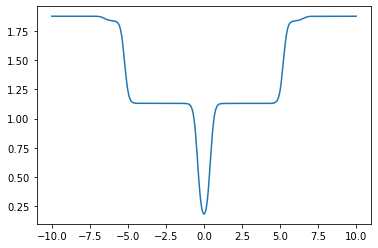

In [17]:
exp = experiment()
x, y = spec2(exp)
plt.plot(x,np.real(y))
plt.show()

## Functions for 3rd order Spec

In [18]:
def conv2(image, kernel, bias=0):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in range(y):
            for j in range(x):
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
    return new_image

In [19]:
def M35(exp, index):
    E = exp.eigenvec; a=E.shape
    [e_sig, er_sig, en_sig, enr_sig] = e_epsilon(exp)
    if not isvector(exp.atom):
        S = exp.atom
        matrxx = np.dot(np.dot(np.conj(E.T),Sx(S)),E)
        matrxy = np.dot(np.dot(np.conj(E.T),Sy(S)),E)
        matrxz = np.dot(np.dot(np.conj(E.T),Sz(S)),E)
        matrxu = np.dot(np.dot(np.dot(S['U'],np.conj(E.T)),S1(S)),E)
        
        J = [0] * 3      
        if len(S['J']) == 1:
            J[0] = S['J']; J[1] = S['J']; J[2] = S['J']
        else:
            J = S['J']
        
        Smatrxx = J[0]*matrxx
        Smatrxy = J[1]*matrxy
        Smatrxz = J[2]*matrxz
        Smatrxu = np.zeros(Smatrxx.shape)
#     else:
#         if exp.entanglement == None:
#             exp.entanglement = False
            
#         nr = exp.position
#         nrj = exp.jposition
#         natoms = 1  #!!!!
#         matrxx = 1
#         matrxx = np.kron(matrxx, sparse(S1(exp.atom)))# !!!
 
#         matrxy = matrxx
#         matrxz = matrxx
#         matrxu = matrxx
    mone = np.ones((1, a[1]))
    
    so1 = [matrxx, matrxy, matrxz, matrxu]
    so2 = [Smatrxx, Smatrxy, Smatrxz, Smatrxu]
    so3 = so1
    e = 0; er = 0; en = 0; enr = 0
    for j in range(4):
        for k in range(4):
            for l in range(4):
                if e_sig[j, k, l] != 0:  # index!!!so1[j,:,index]
                    e = e - np.dot(e_sig[j, k, l], np.kron(np.conj(mone.T), so3[l][index, :][np.newaxis, :])) * \
                        (so2[k].T * np.kron(mone, so1[j][:, index][:, np.newaxis]))
                if er_sig[j, k, l] != 0:
                    er = er - np.dot(er_sig[j, k, l], np.kron(np.conj(mone.T), so3[l][index, :][np.newaxis, :])) * \
                         (so1[k].T * np.kron(mone, so2[j][:, index][:, np.newaxis]))
                if en_sig[j, k, l] != 0:
                    en = en - np.dot(en_sig[j, k, l], np.kron(np.conj(mone.T), so1[l][index, :][np.newaxis, :])) * \
                         (so2[k].T * np.kron(mone, so3[j][:, index][:, np.newaxis]))
                if enr_sig[j, k, l] != 0:
                    enr = enr - np.dot(enr_sig[j, k, l], np.kron(np.conj(mone.T), so1[l][index, :][np.newaxis, :])) * \
                          (so3[k].T * np.kron(mone, so2[j][:, index][:, np.newaxis]))
    
    e = clean(e)
    er = clean(er)
    en = clean(en)
    enr = clean(enr)
    
    return e, er, en, enr
        

In [20]:
def e_epsilon(exp):
    x,y,z,u = etransport(exp)
    
    texp = copy.deepcopy(exp)
    texp.ptip = copy.deepcopy(texp.psample)
    xs,ys,zs,us = etransport(texp)
    # need to build new axis for x, y,z!!!
    mone = np.ones((1,2))
    so1 = [x,y,z,u]
    so2 = [xs, ys, zs, us]
    so3 = [np.conj(x.T), np.conj(y.T), np.conj(z.T), np.conj(u.T)]
    e = np.zeros((4,4,4), dtype = 'complex_')
    er = copy.deepcopy(e); en = copy.deepcopy(e); enr = copy.deepcopy(e)
    for j in range(4):
        for k in range(4):
            for l in range(4):
                for index in range(2):
                    temp = np.kron(np.conj(mone.T), so3[l][index, :][np.newaxis, :]) * (so2[k].T * np.kron(mone, so1[j][:, index][:, np.newaxis]))
                    e[j, k, l] = e[j, k, l] + np.sum(temp)
                    temp = -np.kron(np.conj(mone.T), so3[l][index, :][np.newaxis, :]) * (np.kron(mone, so1[k][:, index][:, np.newaxis]) * so2[j].T)
                    er[j, k, l] = er[j, k, l] + np.sum(temp)
                    temp = -np.kron(mone, so1[l][:, index][:, np.newaxis]) * (so2[k].T * np.kron(np.conj(mone.T), so3[j][index, :][np.newaxis, :]))
                    en[j, k, l] = en[j, k, l] + np.sum(temp)
                    temp = np.kron(mone, so1[l][:, index][:, np.newaxis]) * (np.kron(np.conj(mone.T), so3[k][index, :][np.newaxis, :]) * so2[j].T)
                    enr[j, k, l] = enr[j, k, l] + np.sum(temp)
                    
    return e, er, en, enr

        d = np.linalg.eig(ve)[1]
        ve = np.dot(np.dot(np.linalg.inv(d),ve),d)

In [21]:
def ln_t2(x, e0, T, lt):
    yspan = x[0]-x[-1]; ycenter = (x[0]+x[-1])/2
    i = 2*x.shape[0]
    y = np.linspace(ycenter+yspan,ycenter-yspan,i+1)
    g = np.log((e0+abs(y-ycenter))/(y-ycenter+lt*1j))+np.pi*1j/2
    z = x/T
    k = np.argwhere(abs(z)<1e-3)
    ez = np.exp(z)
    f = -((ez+ez*(z-1))*np.power((ez-1),-2.)-2*ez*(ez*(z-1)+1)*np.power((ez-1),-3.))
    f[k] = 1/6
    f[np.isnan(f)] = 0
#     print(f.shape, g.shape)
#     print(f[:,np.newaxis].shape, g[:,np.newaxis].shape)
    e = 2*convolve2d(f[:,np.newaxis],g[:,np.newaxis],'same')/(T*i)*abs(yspan)

    #e = 2*np.convolve(f.flatten(),g.flatten(),'same')/(T*i)*abs(yspan)
    return e

In [22]:
def spec3(exp, index):
    if exp.jposition == None:
        exp.jposition = exp.position
    
    occ = Occupation(np.real(exp.eigenval),exp.T)
    ve = exp.eigenval
    if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
        d = np.linalg.eig(ve)[1]
        ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
    ve = ve-np.min(np.real(ve))
    
    rate, rater, raten, ratenr = M35(exp, index)
    
    if isvector(exp.xrange):
        x = exp.xrange
    else:
        x = np.conj(np.linspace(abs(exp.xrange),-abs(exp.xrange),1000).T)
        
    y = np.zeros(x.shape);  yn = np.zeros(x.shape)
    yr = np.zeros(x.shape);  ynr = np.zeros(x.shape)
    a = exp.eigenvec.shape
    for mid in range(a[1]):
        for fin in range(a[1]):
            # need to modify for multiple atoms!!!
            if (abs(rate[mid, fin]) + abs(raten[mid, fin]) + \
                    abs(rater[mid, fin]) + abs(ratenr[mid, fin])) > precission ** 2:
                tlog1 = ln_t2(ve[mid] - ve[index] + x, exp.atom['w'], exp.T, exp.lt)
                tlog2 = ln_t2(ve[mid] - ve[index] - x, exp.atom['w'], exp.T, exp.lt)

                en = fstep((ve[fin] - ve[index] - x) / exp.T)[:,np.newaxis]
                ep = fstep((ve[fin] - ve[index] + x) / exp.T)[:,np.newaxis]

                ytemp = -occ[index] * 2 * np.real(rate[mid, fin] * ep * tlog1)
                ytempn = -occ[index] * 2 * np.real(raten[mid, fin] * en * tlog2)
          
                ytempr = -occ[index] * 2 * np.real(rater[mid, fin] * ep * tlog2)
                ytempnr = -occ[index] * 2 * np.real(ratenr[mid, fin] * en * tlog1)

                y = y.flatten() + ytemp.flatten() + ytempn.flatten()
                yr = yr.flatten() + ytempr.flatten() + ytempnr.flatten()
                
    return x, y, yr

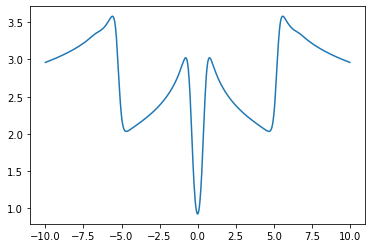

In [23]:
exp = experiment()

nbr_of_atoms = 1
nbr_of_states = exp.eigenvec.shape[1]
maxcnt = nbr_of_states * nbr_of_atoms
cnt = 0; daty = []
occ = Occupation(exp.eigenval,exp.T)
for atnr in range(nbr_of_atoms):
    exp.position = atnr
    exp.jposition = exp.position
    # second order calculation
    x, y = spec2(exp)
    # third order calculation
    y2 = 0
    for i in range(exp.eigenvec.shape[1]):
        if occ[i] > precission:
            x, yl, ylr = spec3(exp, i)
            y2 = y2+(yl+ylr)
#             print(y2.shape, yl.shape, ylr.shape)
        cnt = cnt+1
daty = [daty, y+y2]

# print(y.shape, y2.shape)
plt.plot(x, y+y2)
plt.show()

## Functions for rate calculation

In [24]:
def kernel(m):
    return null_space(m)

In [25]:
def fbox(x):
    x = clean(x, 1e-8)
    y = x/(1-np.exp(-x))
    y[np.isnan(y)] = 1
    return y

In [26]:
def fstep_simple(x):
    return np.power((np.exp(x)+1), -1.)

In [27]:
def spec3rate(exp):
    if exp.jposition == None:
        exp.jposition = exp.position
        
    ve = exp.eigenval
    if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
        d = np.linalg.eig(ve)[1]
        ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
    ve = ve-np.min(np.real(ve))
    
    a = exp.eigenvec.shape
    
    if isvector(exp.xrange):
        rnge = np.max(abs(exp.xrange))
    else:
        rnge = (2*exp.xrange)/999*999.5

    x = np.linspace(rnge, -rnge, 2000)

    out = np.zeros((a[1], a[1], 1000))
    outn = np.zeros((a[1],a[1],1000))
    
    yspan = (x[0]-x[-1])/2; ycenter = (x[0]+x[-1])/2
    i = x.shape[0]
    y = np.linspace(ycenter+yspan, ycenter-yspan, i+1)[np.newaxis,:]#1.    2001.  
    xkernel = fstep_simple(y/exp.T) #1.    2001.  
    
    for index in range(a[1]):
        [rate, rater, raten, ratenr] = M35(exp, index)
        for fin in range(a[1]):
            yp = np.zeros(x.shape); ypr = np.zeros(x.shape)
            yn = np.zeros(x.shape); ynr = np.zeros(x.shape)
            for mid in range(a[1]):
                if abs(rate[mid,fin]) + abs(raten[mid,fin]) \
                    + abs(rater[mid,fin]) + abs(ratenr[mid,fin]) > precission**2:
                    # need to modify for multiple atoms !!!
          
                    tlog1 = ln_t2(ve[mid]-ve[index]+x, exp.atom['w'], exp.T, exp.lt)
                    tlog2 = ln_t2(ve[mid]-ve[index]-x, exp.atom['w'], exp.T, exp.lt)
     
                    en = fstep_simple((ve[fin]-ve[index]-x)/exp.T)[:,np.newaxis]
                    ep = fstep_simple((ve[fin]-ve[index]+x)/exp.T)[:,np.newaxis]
        
                    ytemp = -2*np.real(rate[mid,fin]*ep*tlog1)
                    ytempn = -2*np.real(raten[mid,fin]*en*tlog2)
                    ytempr = -2*np.real(rater[mid,fin]*ep*tlog2)
                    ytempnr = -2*np.real(ratenr[mid,fin]*en*tlog1)

                    yp = yp.flatten()+ytemp.flatten()
                    yn = yn.flatten()+ytempn.flatten()
                    ypr = ypr.flatten()+ytempr.flatten()
                    ynr = ynr.flatten()+ytempnr.flatten()
#                     print(mid,fin,index)
                    
            z = convolve2d((-yp-ypr)[:,np.newaxis],xkernel.flatten()[:,np.newaxis],'same')/1000*np.max(x)
            out[fin,index,:] = z[500:1500].flatten()
            zn = convolve2d((-yn[::-1]-ynr[::-1])[:,np.newaxis], xkernel.flatten()[:,np.newaxis],'same')/1000*np.max(x) 
            outn[fin,index,:] = zn[1499:499:-1].flatten()
#     print(ytemp.shape, ytemp[0], ytemp[-1])
#     print(ytempn.shape, ytempn[0], ytempn[-1])
    return out, outn

In [28]:
def spec3rate_ss(exp):
    if exp.jposition == None:
        exp.jposition = exp.position
        
    ve = exp.eigenval
    if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
        d = np.linalg.eig(ve)[1]
        ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
    ve = ve-np.min(np.real(ve))
    
    a = exp.eigenvec.shape[1]
    
    xrange = np.max((2*ve+20*exp.T).tolist()+[20*exp.T]) #max !!!
    xpoints = int(np.floor(np.max([xrange/exp.T, 1000]))) #floor!!!
    x = np.linspace(-xrange,xrange,xpoints)
    
    f0 = fstep_simple(x/exp.T)
    
    tempexp = copy.deepcopy(exp)
    tempexp.ptip = tempexp.psample
    tempexp.atom['U'] = 0 #!!!
    
    out = np.zeros((a,a))
    for index in range(a):
        [rate, rater, raten, ratenr] = M35(tempexp, index)
        
        for mid in range(a):
            if np.sum(abs(rate[mid,:]) + abs(rater[mid,:])) > precission**2:
                #!!!
                tlog1 = ln_t2(ve[mid]-ve[index]+x, exp.atom['w'], exp.T, exp.lt)
                tlog2 = tlog1[-1:-1:-1]#!!!
                
                for fin in range(a):
                    en = fstep_simple((ve[fin]-ve[index]-x)/exp.T)
                    # en  f0 shape!!!
                    ytemp = np.sum(-2*np.real(rate[mid,fin]*np.conj(en.T)*tlog2*np.conj(f0.T)))
                    ytempr = np.sum(-2*np.real(rater[mid,fin]*np.conj(en)*tlog1*np.conj(f0.T)))
                    
                    out[fin,index] = out[fin,index]+(ytemp+ytempr)*2*xrange/(xpoints-1)
                
    return out
                    

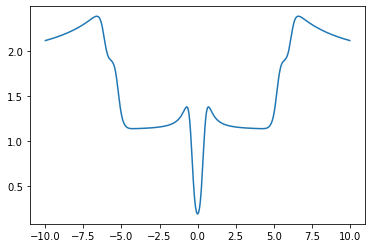

In [34]:
calc = mycalc()
J2_ts = exp.A
ve = np.real(exp.eigenval)
if ve.ndim > 1 and ve.shape[0] == ve.shape[1]:
    ve = diag(ve)
ve = (ve-np.min(np.real(ve)))[:,np.newaxis]
if ve.shape[0] == 1:
    ve = np.conj(ve.T)

ediff = np.kron(np.conj(np.ones((1,ve.shape[0])).T), np.conj(ve.T)) - np.kron(np.ones((1,ve.shape[0])), ve)
y = np.zeros((1000, nbr_of_states))
I = np.zeros((1000,1)); ltime = np.zeros((1000, nbr_of_states))

set_val = 1
exp.position = set_val #gui.sel_spin2.value
exp.jposition = set_val #gui.sel_spin2.value

rate_ts = Rate2nd2(exp)
rate_st = np.conj(rate_ts.T)

texp = copy.deepcopy(exp)
texp.ptip = copy.deepcopy(exp.psample)
texp.atom['U'] = 0 # need to modify for multiple atoms!!!

rate_ss = texp.atom['J'][0]**2*np.conj(Rate2nd2(texp).T)# need to modify for multiple atoms!!!
rate2_ss = (fbox((ediff)/exp.T)*exp.T)*rate_ss

calc_3rd = False #!!!
if calc_3rd:
    exp.jposition = exp.position
    rate3_st, rate3_ts = spec3rate(exp)
    rate3_ts = -rate3_ts
    rate3_ss = spec3rate_ss(exp) * exp.atom['J'][0]**2

    # need to check .*!!!
    rate3_ts = rate3_ts*J2_ts
    rate3_st = -rate3_st*J2_ts


i = 0
x = np.linspace(exp.xrange, -exp.xrange, 1000)
for U in x:
 
    rate2_ts = J2_ts*fbox((ediff+U)/exp.T)*exp.T*rate_ts
    rate2_st = J2_ts*fbox((ediff-U)/exp.T)*exp.T*rate_st
    
    if calc_3rd:
        rate2 = rate2_ss + rate3_ss + rate2_ts + rate2_st \
                + rate3_ts[:,:,i] + rate3_st[:,:,i]
    else:
        rate2 = rate2_ss + rate2_ts + rate2_st
        
    rate21 = rate2-np.eye(rate2.shape[0],rate2.shape[1])*rate2 - diag(np.sum(rate2 - np.eye(rate2.shape[0],rate2.shape[1])*rate2,0))
    ststsol = kernel(rate21)
    sc = np.sum(ststsol,0);
    stst = ststsol[:,0]/sc[0]
    
    y[i,:] = np.conj(stst.T)
    
    ltime[i,:] = np.sum(rate21-rate21*np.eye(rate21.shape[0],rate21.shape[1]), 0)
    if calc_3rd:
        
        I[i] = np.sum(np.dot(rate2_ts, stst)) - np.sum(np.dot(rate2_st, stst)) \
                + np.sum(np.dot(rate3_ts[:,:,i], stst)) - np.sum(np.dot(rate3_st[:,:,i], stst))
    else:
        I[i] = np.sum(np.dot(rate2_ts,stst)) - np.sum(np.dot(rate2_st,stst))
    
    i = i+1
    

di = -(I[1:]-I[:-1])*500/exp.xrange
xx = x-exp.xrange/999
xx = xx[:-1]
di = di/exp.A

calc.spec_raw = np.vstack((np.conj(xx.T),di.flatten())).T

calc.occ = [np.conj(x.T),y]
calc.lifetime = [np.conj(x.T),np.power(ltime,-1.) *6.582e-13*2]
                
if len(calc.spec) == 0:
    if not exp.rate_calc:
        if normalize:
            atnr = exp.position
            # need to modify for multiple atoms !!!
            scale = 2*np.power(exp.atom['S']*(exp.atom['S']+1) + np.power(exp.atom['U'], 2.),-1.)
        else:
            scale=exp.A
    else:
        if normalize:
            scale=1
        else:
            scale=experiment.A
            
    calc.spec = calc.spec_raw[:,0]+exp.x0
    for i in range(1,calc.spec_raw.shape[1]):
        calc.spec = np.vstack((calc.spec, (calc.spec_raw[:,i] + exp.y0 + exp.b * calc.spec_raw[:,0]) *scale))

plt.plot(calc.spec[0,:],calc.spec[1,:])
plt.show()

## Eample Co/CuN

(1000, 2)


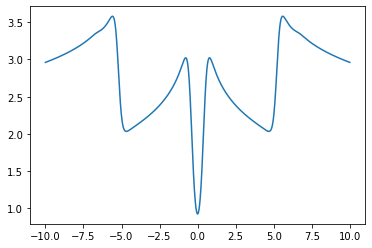

In [33]:
data = np.loadtxt('./co.dat')
print(data.shape)
xx = data[:,0]; yy=data[:,1]
plt.plot(xx,yy)
plt.show()

### Draft

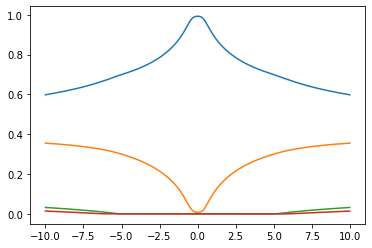

[0.81308685 0.18691315 0.         0.        ]


NameError: name 'rate' is not defined

In [32]:
plt.plot(x,np.real(y))
plt.show()
print(y[399])


# ve = np.real(exp.eigenval)
# if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
#     d = np.linalg.eig(ve)[1]
#     ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
# ve = ve-np.min(np.real(ve))
# occ = Occupation(ve, exp.T)
# rate = np.conj(Rate2nd2(exp).T)
# rateneg = np.conj(rate.T)

# if isvector(exp.xrange):
#     x = exp.xrange
# else:
#     x = np.conj(np.linspace(abs(exp.xrange),-abs(exp.xrange),1000).T)

# y = 0
# a = exp.eigenvec.shape

i=1;j=3
en = (ve[j]-ve[i]-x)/abs(exp.T)
ep = (ve[j]-ve[i]+x)/abs(exp.T)
ytemp = occ[i]*(rate[i,j]*fstep(ep)+rateneg[i,j]*fstep(en))
# y = y+ytemp
print(ytemp[399])
# 0.10704051809022191   1.0146182422150727   1.829131071952448e-15  2.1719116369921174e-23
# 0.007966597328811654  0.0007288238699355763  1.4546967751378572e-16  3.916384004960008e-22

# print(y[399],  rateneg[3,3], ep[399], ytemp[399], abs(exp.T))
# for k in range(a[1]):
#     print(occ[k]> precission)

In [ ]:
occ = Occupation(np.real(exp.eigenval),exp.T)
ve = exp.eigenval
if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
    d = np.linalg.eig(ve)[1]
    ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
ve = ve-np.min(np.real(ve))
mid = 0; index = 0
tlog1 = ln_t2(ve[mid] - ve[index] + x, exp.atom['w'], exp.T, exp.lt)
# tlog2 = ln_t2(ve[mid] - ve[index] - x, exp.atom['w'], exp.T, exp.lt)
print(tlog1.shape, tlog1[0])

In [ ]:
# rate, rater, raten, ratenr = M35(exp, 0)
# print(rate)
[e_sig, er_sig, en_sig, enr_sig] = e_epsilon(exp)
print(e_sig.shape, e_sig)
# for mid in range(4):
#     for fin in range(4):
#         print('---',mid, fin,'---')
#         print(abs(rate[mid, fin]) + abs(raten[mid, fin]) + 
#              abs(rater[mid, fin]) + abs(ratenr[mid, fin]))

In [ ]:
x,y,z,u = etransport(exp)

texp = copy.deepcopy(exp)
texp.ptip = copy.deepcopy(texp.psample)
xs,ys,zs,us = etransport(texp)
# need to build new axis for x, y,z!!!
mone = np.ones((1,2))
so1 = [x,y,z,u]
so2 = [xs, ys, zs, us]
so3 = [np.conj(x.T), np.conj(y.T), np.conj(z.T), np.conj(u.T)]
e = np.zeros((4,4,4))
er = copy.deepcopy(e); en = copy.deepcopy(e); enr = copy.deepcopy(e)
j=0;k=1;l=3;index=0
temp = np.kron(mone, so1[l][:, index][:, np.newaxis]) * (np.kron(np.conj(mone.T), so3[k][index, :][np.newaxis, :]) * so2[j].T)
enr[j, k, l] = enr[j, k, l] + np.sum(temp)
print(temp)
    
    
# print(mone.shape, so1[0][:,0][:, np.newaxis].shape)
# print(mone.T.shape, so1[0][0,:][np.newaxis, :].shape)
# print(np.kron(np.conj(mone.T), so3[0][0, :][np.newaxis, :]))
# print(so2[0].T * np.kron(mone, so1[0][:, 0][:, np.newaxis]))
# n = 2
# print((abs(rate[mid, fin]) + abs(raten[mid, fin]) + \
#                     abs(rater[mid, fin]) + abs(ratenr[mid, fin])))

In [ ]:
if exp.jposition == None:
    exp.jposition = exp.position

ve = exp.eigenval
if len(ve.shape) > 1 and ve.shape[0] == ve.shape[1]:
    d = np.linalg.eig(ve)[1]
    ve = np.dot(np.dot(np.linalg.inv(d),ve),d)
ve = ve-np.min(np.real(ve))

a = exp.eigenvec.shape

if isvector(exp.xrange):
    rnge = np.max(abs(exp.xrange))
else:
    rnge = (2*exp.xrange)/999*999.5

x = np.linspace(rnge, -rnge, 2000)

out = np.zeros((a[1], a[1], 1000))
outn = np.zeros((a[1],a[1],1000))

yspan = (x[0]-x[-1])/2; ycenter = (x[0]+x[-1])/2
i = x.shape[0]
y = np.linspace(ycenter+yspan, ycenter-yspan, i+1)[np.newaxis,:]#1.    2001.  
xkernel = fstep_simple(y/exp.T) #1.    2001.  
yp = np.zeros(x.shape); ypr = np.zeros(x.shape)
yn = np.zeros(x.shape); ynr = np.zeros(x.shape)
mid= 2;  fin=3; index =0
[rate, rater, raten, ratenr] = M35(exp, index)
tlog1 = ln_t2(ve[mid]-ve[index]+x, exp.atom['w'], exp.T, exp.lt)
tlog2 = ln_t2(ve[mid]-ve[index]-x, exp.atom['w'], exp.T, exp.lt)
en = fstep_simple((ve[fin]-ve[index]-x)/exp.T)[:,np.newaxis]
ep = fstep_simple((ve[fin]-ve[index]+x)/exp.T)[:,np.newaxis]
ytemp = -2*np.real(rate[mid,fin]*ep*tlog1)
ytempn = -2*np.real(raten[mid,fin]*en*tlog2)
ytempr = -2*np.real(rater[mid,fin]*ep*tlog2)
ytempnr = -2*np.real(ratenr[mid,fin]*en*tlog1)
yp = yp.flatten()+ytemp.flatten()
yn = yn.flatten()+ytempn.flatten()
ypr = ypr.flatten()+ytempr.flatten()
ynr = ynr.flatten()+ytempnr.flatten()
z = convolve2d((-yp-ypr)[:,np.newaxis],xkernel.flatten()[:,np.newaxis],'same')/1000 * np.max(x)
out[fin,index,:] = z[500:1500].flatten()
zn = convolve2d((-yn[::-1]-ynr[::-1])[:,np.newaxis], xkernel.flatten()[:,np.newaxis],'same')/1000*np.max(x) 
outn[fin,index,:] = zn[1499:499:-1].flatten()

print(yp.shape, yp[0], yp[-1])
print(yn.shape, yn[0], yn[-1])
print(z.shape, z[0], z[-1], zn[0], zn[-1])
print('--',out[fin,index,0], out[fin,index,-1])
print('--',outn[fin,index,0], outn[fin,index,-1])
print('z', z[500:1500].flatten()[0],  z[500:1500].flatten()[-1])
print('zn', zn[1499:-1:501].flatten()[0], zn[1499:-1:500].flatten()[-1])
print(zn[500])